# Task 2: RNN application -- Tweet Sentiment Analysis

In [1]:
# Import modules
from __future__ import print_function
import tensorflow as tf
import numpy as np
import json
import time
import matplotlib.pyplot as plt
import pickle

# Plot configurations
% matplotlib inline
# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
% load_ext autoreload
% autoreload 2

### Load data

In [196]:
train_data = json.load(open('tweets_data/trainTweets_preprocessed.json', 'r'))
print(train_data[0])
train_data = list(map(lambda row:(np.array(row[0],dtype=np.int32),str(row[1])),train_data))
print(train_data[0])

[[345, 55, 3679, 1796, 30, 7, 211, 474, 260, 29, 59, 33, 1, 1, 1, 1, 1, 1, 1, 1], '0']
(array([ 345,   55, 3679, 1796,   30,    7,  211,  474,  260,   29,   59,
         33,    1,    1,    1,    1,    1,    1,    1,    1], dtype=int32), '0')


In [2]:
with open("./tweets_data/vocabulary.pkl", "rb") as f:
    vocabulary = pickle.load(f)

# load our data and separate it into tweets and labels
train_data = json.load(open('tweets_data/trainTweets_preprocessed.json', 'r'))
print(train_data[0])
train_data = list(map(lambda row:(np.array(row[0],dtype=np.int32),str(row[1])),train_data))
print(train_data[0])
train_tweets = np.array([t[0] for t in train_data])
train_labels = np.array([int(t[1]) for t in train_data])

test_data = json.load(open('tweets_data/testTweets_preprocessed.json', 'r'))
test_data = list(map(lambda row:(np.array(row[0],dtype=np.int32),str(row[1])),test_data))
test_tweets = np.array([t[0] for t in test_data])
test_labels = np.array([int(t[1]) for t in test_data])

print("size of original train set: {}".format(len(train_tweets)))
print("size of original test set: {}".format(len(test_tweets)))

# only select first 1000 test sample for test
test_tweets = test_tweets[:1000]
test_labels = test_labels[:1000]

print("*"*100)
print("size of train set: {}, #positive: {}, #negative: {}".format(len(train_tweets), np.sum(train_labels), len(train_tweets)-np.sum(train_labels)))
print("size of test set: {}, #positive: {}, #negative: {}".format(len(test_tweets), np.sum(test_labels), len(test_tweets)-np.sum(test_labels)))

# show text of the idx-th train tweet
# The 'padtoken' is used to ensure each tweet has the same length
idx = 100
train_text = [vocabulary[x] for x in train_tweets[idx]]
print(train_text)
sentiment_label = ["negative", "positive"]
print("sentiment: {}".format(sentiment_label[train_labels[idx]]))

size of original train set: 60000
size of original test set: 20000
****************************************************************************************************
size of train set: 60000, #positive: 30055, #negative: 29945
size of test set: 1000, #positive: 510, #negative: 490
['it', 'will', 'help', 'relieve', 'your', 'stress', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken']
sentiment: positive


## Part 1: LSTM Encoder

### train a single-layer lstm network

First of all, we'll build a single-layer LSTM network for the analysis. The network structure is the following:

![](./img/singleLSTM.png)

<span style="color:red">__TODO:__</span> Below, we've defined the network for you. Please read the code carefully to make sure you understand it. Then, please write a training function to train this network. The settings are:

1. Train the network for 1000 iterations. In each iteration, use batch_size samples to train the network.
2. For every 50 iterations, apply the network on the test set, and print out the test accuracy and mean loss.

With these settings, what accuracy could you get? You can try to change some stuff in the network to see if you could get a better accuracy (this is optional).

In [27]:
# define a linear layer, y = x*w + b
def linear(input_, output_size, name, init_bias=0.0):
    shape = input_.get_shape().as_list()
    with tf.variable_scope(name):
        init = tf.truncated_normal([shape[-1], output_size], mean=0.0, stddev=1.0 / shape[-1]**0.5)
        W = tf.get_variable("weight", initializer=init)
    if init_bias is None:
        return tf.matmul(input_, W)
    with tf.variable_scope(name):
        b = tf.get_variable("bias", [output_size], initializer=tf.constant_initializer(init_bias))
    return tf.matmul(input_, W) + b

In [67]:
# set variables
tweet_size = 20
hidden_size = 100
vocab_size = 7597
batch_size = 64

# this just makes sure that all our following operations will be placed in the right graph.
tf.reset_default_graph()

# make placeholders for data we'll feed in
tweets = tf.placeholder(tf.int32, [None, tweet_size])
labels = tf.placeholder(tf.float32, [None])

tweets_onehot = tf.one_hot(tweets, depth=vocab_size, axis=-1)

# define the lstm cell
lstm_cell = tf.contrib.rnn.LSTMCell(hidden_size)

# define the op that runs the LSTM, across time, on the data
init_state = lstm_cell.zero_state(batch_size, tf.float32)
outputs, final_state = tf.nn.dynamic_rnn(lstm_cell, tweets_onehot, initial_state=init_state, dtype=tf.float32)

# define that our final sentiment logit is a linear function of the final state of the LSTM
sentiment = linear(final_state[-1], 1, name="output")

# define cross entropy/sigmoid loss function
sentiment = tf.squeeze(sentiment, [1])
loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=sentiment, labels=labels)
loss = tf.reduce_mean(loss)

# compute accuracy
prob = tf.nn.sigmoid(sentiment)
prediction = tf.to_float(tf.greater_equal(prob, 0.5))
acc = tf.to_float(tf.equal(prediction, labels))
acc = tf.reduce_mean(acc)

# define optimizer
trainer = tf.train.AdamOptimizer()
gradients = trainer.compute_gradients(loss)
gradients_clipped = [(tf.clip_by_value(t[0],-1,1),t[1]) for t in gradients]
optimizer = trainer.apply_gradients(gradients_clipped)

In [111]:
# Training function
import random
num_steps = 1000
total_train_samples = train_tweets.shape[0]
batch_count = 0
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for step in range(num_steps):
        # TODO: get data for a batch
        if (batch_count+1)*batch_size > total_train_samples:
            batch_tweets = train_tweets[batch_count*batch_size:60000]
            batch_labels = train_labels[batch_count*batch_size:60000]
            append_size = batch_size - batch_tweets.shape[0]
            batch_tweets = np.concatenate((batch_tweets, np.array(random.sample(list(train_tweets), append_size))))
            batch_labels = np.concatenate((batch_labels, np.array(random.sample(list(train_labels), append_size))))
            batch_count = 0
        else:
            batch_tweets = train_tweets[batch_count*batch_size:(batch_count+1)*batch_size]
            batch_labels = train_labels[batch_count*batch_size:(batch_count+1)*batch_size]
            batch_count += 1

        # TODO: run the 'optimizer', 'loss', and 'acc' operations in the graph using the batch data
        _, train_loss, train_acc = sess.run([optimizer, loss, acc], feed_dict={tweets:batch_tweets, labels:batch_labels})
        if (step % 50 == 0 or step == 999):
            # TODO: get test accuracy and loss, and print them out.
            tbc = 0
            total_loss = 0
            total_acc = 0
            for i in range(1000//batch_size+1):
                if (tbc+1)*batch_size <= 1000:
                    batch_test_tweets = test_tweets[tbc*batch_size:(tbc+1)*batch_size]
                    batch_test_labels = test_labels[tbc*batch_size:(tbc+1)*batch_size]
                    tbc += 1
                else:
                    batch_test_tweets = test_tweets[tbc*batch_size:1000]
                    batch_test_labels = test_labels[tbc*batch_size:1000]
                    append_size = batch_size - batch_test_tweets.shape[0]
                    batch_test_tweets = np.concatenate((batch_test_tweets, np.array(random.sample(list(test_tweets), append_size))))
                    batch_test_labels = np.concatenate((batch_test_labels, np.array(random.sample(list(test_labels), append_size))))
                    tbc = 0
                batch_loss, batch_acc = sess.run([loss, acc], feed_dict={tweets:batch_test_tweets, labels:batch_test_labels})
                total_loss += batch_loss
                total_acc += batch_acc
            total_loss = total_loss/(1000//batch_size+1)
            total_acc = total_acc/(1000//batch_size+1)
#             print("Training step: {0}\tTest Loss = {1}\tTest Accuracy = {2}".format(step, batch_loss, batch_acc))
            print("Training step: {0}\tTest Loss = {1}\tTest Accuracy = {2}".format(step, total_loss, total_acc))
            

Training step: 0	Test Loss = 0.6919908486306667	Test Accuracy = 0.5380859375
Training step: 50	Test Loss = 0.6777697429060936	Test Accuracy = 0.5673828125
Training step: 100	Test Loss = 0.6033436842262745	Test Accuracy = 0.666015625
Training step: 150	Test Loss = 0.5785716474056244	Test Accuracy = 0.69140625
Training step: 200	Test Loss = 0.551995737478137	Test Accuracy = 0.73046875
Training step: 250	Test Loss = 0.545532738789916	Test Accuracy = 0.732421875
Training step: 300	Test Loss = 0.548671206459403	Test Accuracy = 0.7333984375
Training step: 350	Test Loss = 0.5558816511183977	Test Accuracy = 0.712890625
Training step: 400	Test Loss = 0.5441414806991816	Test Accuracy = 0.7333984375
Training step: 450	Test Loss = 0.5322381630539894	Test Accuracy = 0.7294921875
Training step: 500	Test Loss = 0.5249098166823387	Test Accuracy = 0.7431640625
Training step: 550	Test Loss = 0.5242468249052763	Test Accuracy = 0.7431640625
Training step: 600	Test Loss = 0.523760087788105	Test Accuracy = 

### train a two-layer lstm network

Next, we look at a slightly more difficult network structure: a double-layer LSTM. The output of the first LSTM cell is propagated to the second LSTM cell. We only need to make small modifications to the previous network to construct this one.

![](./img/doubleLSTM.png)

<span style="color:red">__TODO:__</span> Define this double-layer LSTM in the below notebook cell. You can copy the single-layer network code and make changes to it. After that, train the network using the function you just wrote.

Hint: Use **tf.contrib.rnn.MultiRNNCell**. You'll find there are only 2-3 lines of code that need to be changed.

In [15]:
# define a linear layer, y = x*w + b
def linear_multi(input_, output_size, name, init_bias=0.0):
    shape = input_.get_shape().as_list()
    with tf.variable_scope(name):
        init = tf.truncated_normal([shape[-1], output_size], mean=0.0, stddev=1.0 / shape[-1]**0.5)
        W = tf.get_variable("weight", initializer=init)
    if init_bias is None:
        return tf.matmul(input_, W)
    with tf.variable_scope(name):
        b = tf.get_variable("bias", [output_size], initializer=tf.constant_initializer(init_bias))
    return tf.matmul(input_, W) + b

In [112]:
# YOUR DOUBLE-LAYER LSTM Here
# set variables
tweet_size = 20
hidden_size = 100
vocab_size = 7597
batch_size = 64
num_layers = 2

# this just makes sure that all our following operations will be placed in the right graph.
tf.reset_default_graph()

# make placeholders for data we'll feed in
tweets = tf.placeholder(tf.int32, [None, tweet_size])
labels = tf.placeholder(tf.float32, [None])

tweets_onehot = tf.one_hot(tweets, depth=vocab_size, axis=-1)

# define the lstm cell
lstm_cell = tf.contrib.rnn.LSTMCell(hidden_size)
stacked_rnn = []
for iiLyr in range(2):
    stacked_rnn.append(tf.contrib.rnn.LSTMCell(hidden_size))
# lstm_cell = tf.contrib.rnn.MultiRNNCell([lstm_cell] * num_layers, state_is_tuple=True)
lstm_cell = tf.contrib.rnn.MultiRNNCell(cells=stacked_rnn, state_is_tuple=True)

# define the op that runs the LSTM, across time, on the data
init_state = lstm_cell.zero_state(batch_size, tf.float32)
outputs, final_state = tf.nn.dynamic_rnn(lstm_cell, tweets_onehot, initial_state=init_state, dtype=tf.float32)

# define that our final sentiment logit is a linear function of the final state of the LSTM
sentiment = linear(final_state[-1].c, 1, name="output")

# define cross entropy/sigmoid loss function
sentiment = tf.squeeze(sentiment, [1])
loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=sentiment, labels=labels)
loss = tf.reduce_mean(loss)

# compute accuracy
prob = tf.nn.sigmoid(sentiment)
prediction = tf.to_float(tf.greater_equal(prob, 0.5))
acc = tf.to_float(tf.equal(prediction, labels))
acc = tf.reduce_mean(acc)

# define optimizer
trainer = tf.train.AdamOptimizer()
gradients = trainer.compute_gradients(loss)
gradients_clipped = [(tf.clip_by_value(t[0],-1,1),t[1]) for t in gradients]
optimizer = trainer.apply_gradients(gradients_clipped)

In [113]:
# Training function
num_steps = 1000
total_train_samples = train_tweets.shape[0]
batch_count = 0
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for step in range(num_steps):
        # TODO: get data for a batch
        if (batch_count+1)*batch_size > total_train_samples:
            batch_tweets = train_tweets[batch_count*batch_size:60000]
            batch_labels = train_labels[batch_count*batch_size:60000]
            append_size = batch_size - batch_tweets.shape[0]
            batch_tweets = np.concatenate((batch_tweets, np.array(random.sample(list(train_tweets), append_size))))
            batch_labels = np.concatenate((batch_labels, np.array(random.sample(list(train_labels), append_size))))
            batch_count = 0
        else:
            batch_tweets = train_tweets[batch_count*batch_size:(batch_count+1)*batch_size]
            batch_labels = train_labels[batch_count*batch_size:(batch_count+1)*batch_size]
            batch_count += 1

        # TODO: run the 'optimizer', 'loss', and 'acc' operations in the graph using the batch data
        _, train_loss, train_acc = sess.run([optimizer, loss, acc], feed_dict={tweets:batch_tweets, labels:batch_labels})
        if (step % 50 == 0 or step == 999):
            # TODO: get test accuracy and loss, and print them out.
            tbc = 0
            total_loss = 0
            total_acc = 0
            for i in range(1000//batch_size+1):
                if (tbc+1)*batch_size <= 1000:
                    batch_test_tweets = test_tweets[tbc*batch_size:(tbc+1)*batch_size]
                    batch_test_labels = test_labels[tbc*batch_size:(tbc+1)*batch_size]
                    tbc += 1
                else:
                    batch_test_tweets = test_tweets[tbc*batch_size:1000]
                    batch_test_labels = test_labels[tbc*batch_size:1000]
                    append_size = batch_size - batch_test_tweets.shape[0]
                    batch_test_tweets = np.concatenate((batch_test_tweets, np.array(random.sample(list(test_tweets), append_size))))
                    batch_test_labels = np.concatenate((batch_test_labels, np.array(random.sample(list(test_labels), append_size))))
                    tbc = 0
                batch_loss, batch_acc = sess.run([loss, acc], feed_dict={tweets:batch_test_tweets, labels:batch_test_labels})
                total_loss += batch_loss
                total_acc += batch_acc
            total_loss = total_loss/(1000//batch_size+1)
            total_acc = total_acc/(1000//batch_size+1)
#             print("Training step: {0}\tTest Loss = {1}\tTest Accuracy = {2}".format(step, batch_loss, batch_acc))
            print("Training step: {0}\tTest Loss = {1}\tTest Accuracy = {2}".format(step, total_loss, total_acc))
            

Training step: 0	Test Loss = 0.6916129216551781	Test Accuracy = 0.5537109375
Training step: 50	Test Loss = 0.6315515786409378	Test Accuracy = 0.6513671875
Training step: 100	Test Loss = 0.5869773030281067	Test Accuracy = 0.6806640625
Training step: 150	Test Loss = 0.5843572057783604	Test Accuracy = 0.705078125
Training step: 200	Test Loss = 0.5584374777972698	Test Accuracy = 0.732421875
Training step: 250	Test Loss = 0.5471960697323084	Test Accuracy = 0.7294921875
Training step: 300	Test Loss = 0.536975335329771	Test Accuracy = 0.73828125
Training step: 350	Test Loss = 0.5487573109567165	Test Accuracy = 0.732421875
Training step: 400	Test Loss = 0.5291043929755688	Test Accuracy = 0.7529296875
Training step: 450	Test Loss = 0.5473901927471161	Test Accuracy = 0.7421875
Training step: 500	Test Loss = 0.5235076807439327	Test Accuracy = 0.751953125
Training step: 550	Test Loss = 0.5301526021212339	Test Accuracy = 0.73828125
Training step: 600	Test Loss = 0.5308112520724535	Test Accuracy = 0

## Part 2: Embedding Lookup layer

![](./img/embedding.png)

###  Define an embedding layer

It's not hard to imagine in the previous practices, the input we fed in are very sparse because each word was represented as a one-hot vector. This makes it difficult for the network to understand what story the input data is telling. 

Word embedding: instead of using a one-hot vector to represent each word, we can add an word embedding matrix in which each word is represented as a low-dimensional vector. Note that this representation is not sparse any more, because we're working in a continuous vector space now. Words that share similar/related semantic meaning should be 'close to each other' in this vector space (we could define a distance measure to estimate the closeness). 

[https://www.tensorflow.org/tutorials/word2vec](https://www.tensorflow.org/tutorials/word2vec)

<span style="color:red">__TODO:__</span> Take a look at the website above, and write a function to do the embedding. The website itself is a very good tutorial.

Hint: Use **tf.nn.embedding_lookup**

In [205]:
import math
def embedding(input_, vocab_size, output_size, name):
    """
    1. Define an embedding matrix
    2. return both the lookup results and the embedding matrix.
    """
    with tf.variable_scope(name):
        embedding = tf.get_variable("embedding", [vocab_size, output_size], tf.float32, tf.random_normal_initializer(stddev=1.0 / math.sqrt(output_size)))
    return [tf.nn.embedding_lookup(embedding, input_),embedding]

### Train a single lstm network with embedding layer

<span style="color:red">__TODO:__</span> Build a single-layer LSTM network according to the network structure. Then, train the network with the training function you wrote.

In [206]:
# YOUR EMBEDDING SINGLE-LAYER LSTM HERE
# set variables
tweet_size = 20
hidden_size = 100
vocab_size = 7597
batch_size = 64

# this just makes sure that all our following operations will be placed in the right graph.
tf.reset_default_graph()

# make placeholders for data we'll feed in
tweets = tf.placeholder(tf.int32, [None, tweet_size])
labels = tf.placeholder(tf.float32, [None])

[embedding, matrix] = embedding(tweets, vocab_size, hidden_size, name="word_embedding")

# define the lstm cell
lstm_cell = tf.contrib.rnn.LSTMCell(hidden_size)

# define the op that runs the LSTM, across time, on the data
init_state = lstm_cell.zero_state(batch_size, tf.float32)
outputs, final_state = tf.nn.dynamic_rnn(lstm_cell, embedding, initial_state=init_state, dtype=tf.float32)

# define that our final sentiment logit is a linear function of the final state of the LSTM
sentiment = linear(final_state[-1], 1, name="output")

# define cross entropy/sigmoid loss function
sentiment = tf.squeeze(sentiment, [1])
loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=sentiment, labels=labels)
loss = tf.reduce_mean(loss)

# compute accuracy
prob = tf.nn.sigmoid(sentiment)
prediction = tf.to_float(tf.greater_equal(prob, 0.5))
acc = tf.to_float(tf.equal(prediction, labels))
acc = tf.reduce_mean(acc)

# define optimizer
trainer = tf.train.AdamOptimizer()
gradients = trainer.compute_gradients(loss)
gradients_clipped = [(tf.clip_by_value(t[0],-1,1),t[1]) for t in gradients]
optimizer = trainer.apply_gradients(gradients_clipped)

In [145]:
# Training function
num_steps = 1000
total_train_samples = train_tweets.shape[0]
batch_count = 0
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for step in range(num_steps):
        # TODO: get data for a batch
        if (batch_count+1)*batch_size > total_train_samples:
            batch_tweets = train_tweets[batch_count*batch_size:60000]
            batch_labels = train_labels[batch_count*batch_size:60000]
            append_size = batch_size - batch_tweets.shape[0]
            batch_tweets = np.concatenate((batch_tweets, np.array(random.sample(list(train_tweets), append_size))))
            batch_labels = np.concatenate((batch_labels, np.array(random.sample(list(train_labels), append_size))))
            batch_count = 0
        else:
            batch_tweets = train_tweets[batch_count*batch_size:(batch_count+1)*batch_size]
            batch_labels = train_labels[batch_count*batch_size:(batch_count+1)*batch_size]
            batch_count += 1

        # TODO: run the 'optimizer', 'loss', and 'acc' operations in the graph using the batch data
        _, train_loss, train_acc = sess.run([optimizer, loss, acc], feed_dict={tweets:batch_tweets, labels:batch_labels})
        if (step % 50 == 0 or step == 999):
            # TODO: get test accuracy and loss, and print them out.
            tbc = 0
            total_loss = 0
            total_acc = 0
            for i in range(1000//batch_size+1):
                if (tbc+1)*batch_size <= 1000:
                    batch_test_tweets = test_tweets[tbc*batch_size:(tbc+1)*batch_size]
                    batch_test_labels = test_labels[tbc*batch_size:(tbc+1)*batch_size]
                    tbc += 1
                else:
                    batch_test_tweets = test_tweets[tbc*batch_size:1000]
                    batch_test_labels = test_labels[tbc*batch_size:1000]
                    append_size = batch_size - batch_test_tweets.shape[0]
                    batch_test_tweets = np.concatenate((batch_test_tweets, np.array(random.sample(list(test_tweets), append_size))))
                    batch_test_labels = np.concatenate((batch_test_labels, np.array(random.sample(list(test_labels), append_size))))
                    tbc = 0
                batch_loss, batch_acc = sess.run([loss, acc], feed_dict={tweets:batch_test_tweets, labels:batch_test_labels})
                total_loss += batch_loss
                total_acc += batch_acc
            total_loss = total_loss/(1000//batch_size+1)
            total_acc = total_acc/(1000//batch_size+1)
#             print("Training step: {0}\tTest Loss = {1}\tTest Accuracy = {2}".format(step, batch_loss, batch_acc))
            print("Training step: {0}\tTest Loss = {1}\tTest Accuracy = {2}".format(step, total_loss, total_acc))
    embedding_matrix = sess.run(matrix)
            

Training step: 0	Test Loss = 0.692418772727251	Test Accuracy = 0.5625
Training step: 50	Test Loss = 0.6726235039532185	Test Accuracy = 0.5654296875
Training step: 100	Test Loss = 0.6059901677072048	Test Accuracy = 0.6748046875
Training step: 150	Test Loss = 0.5706573445349932	Test Accuracy = 0.7021484375
Training step: 200	Test Loss = 0.5588216260075569	Test Accuracy = 0.7109375
Training step: 250	Test Loss = 0.5511057879775763	Test Accuracy = 0.7255859375
Training step: 300	Test Loss = 0.5452409125864506	Test Accuracy = 0.7431640625
Training step: 350	Test Loss = 0.5502950884401798	Test Accuracy = 0.7255859375
Training step: 400	Test Loss = 0.5385589972138405	Test Accuracy = 0.748046875
Training step: 450	Test Loss = 0.5290400646626949	Test Accuracy = 0.73828125
Training step: 500	Test Loss = 0.5183979161083698	Test Accuracy = 0.74609375
Training step: 550	Test Loss = 0.524322560057044	Test Accuracy = 0.7431640625
Training step: 600	Test Loss = 0.5340418852865696	Test Accuracy = 0.728

### Visualize word vectors via tSNE

<span style="color:red">__TODO:__</span>

First, you need to retrieve **embedding matrix** from the network. Then use tSNE to reduce each low-dimensional word vector into a 2D vector. 

And then, you should visualize some interesting word pairs in 2D panel. You may find **scatter** function in **matplotlib.pyplot** useful.


Hint: You can use **TSNE** tool provided in **scikit-learn**. And if you encounter dead kernel problem caused by "Intel MKL FATAL ERROR: Cannot load libmkl_avx.so or libmkl_def.so", please reinstall scikit-learn without MKL, ie., **conda install nomkl numpy scipy scikit-learn numexpr**. 

Here we provide some word pairs for you, like female-male or country-capital. And you can observe that these word-pair will look parallel with each other in a 2D tSNE panel. And you can find some other words and explore their relationship.

The result for female-male pairs should look like, and you will observe that king-men and queen-women are parallel to each other in a 2D panel.


![](./img/tsne_female_male.png)

In [37]:
female_male = ["men", "women", "king", "queen"]
country_capital = ["spain", "madrid", "italy", "rome", "japan", "tokyo"]
# you can try some other words

In [201]:
print(embedding_matrix)
print(embedding_matrix.shape)

[[ 0.0240817   0.05222159 -0.16442859 ...,  0.13582884 -0.02433185
   0.08239289]
 [-0.10070354 -0.18201712 -0.02155879 ...,  0.00475563 -0.03716514
  -0.0293594 ]
 [-0.05452937 -0.25616896  0.00990555 ..., -0.02859567  0.15534376
   0.11747152]
 ..., 
 [ 0.04177171  0.14334226 -0.11787194 ...,  0.11438694  0.09130663
   0.06288854]
 [ 0.11741514  0.04650451  0.02019694 ..., -0.13576078  0.0216529
  -0.13819733]
 [ 0.02748527  0.01781574  0.07417218 ..., -0.04820335  0.04390398
   0.02232707]]
(7597, 100)


In [147]:
from sklearn.manifold import TSNE
from matplotlib.pyplot import scatter
tsne = TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(embedding_matrix)


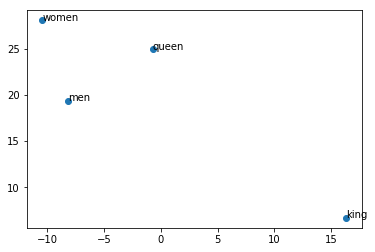

In [200]:
xlist = []
ylist = []
for words in female_male:
    [x, y] = X_tsne[vocabulary.tolist().index(words)]
    xlist.append(x)
    ylist.append(y)
fig, ax = plt.subplots()
ax.scatter(xlist, ylist)

for i, txt in enumerate(female_male):
    ax.annotate(txt, (xlist[i],ylist[i]))

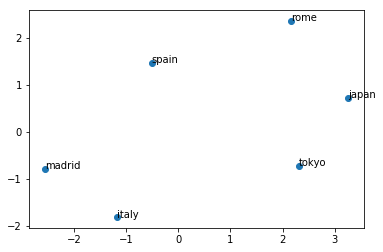

In [203]:
xlist2 = []
ylist2 = []
for words in country_capital:
    [x, y] = X_tsne[vocabulary.tolist().index(words)]
    xlist2.append(x)
    ylist2.append(y)
fig, ax = plt.subplots()
ax.scatter(xlist2, ylist2)

for i, txt in enumerate(country_capital):
    ax.annotate(txt, (xlist2[i],ylist2[i]))

#### <span style="color:red">TODO: </span> describe your observation of these word vectors

Answer: Similar words will be close to each others. And we can observe that the men-king pair is parallel to the women-queen pair, japan-tokyo is parallel to italy-rome and spain-madrid pairs.